# Titanic: Machine Learning from Disaster

(https://www.kaggle.com/c/titanic/overview)

We start off by importing the basic Python libraries that will be needed throughout the whole time of this notebook and by loading the datasets into pandas DataFrames.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Exploratory Data Analysis (EDA)

The first step when tackling a new challenge or project should always be to first get to know the data. Therefore, we will start by looking at the data and the variables.

In [4]:
train.shape, test.shape

((891, 12), (418, 11))

We see that the training set contains 891 observations (rows) and 12 variables or features (columns). The test set contains less observations (418) and only 11 features. We will at first take a glimpse at the first few rows of each dataset.

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.columns, test.columns

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'))

We can see that both datasets contain exactly the same variables except for "Survived", which is missing in the test dataset since this is the variable we want to predict. It is a dummy variable, 1 means survived, 0 means not survived. The "Name" variable has unique values for every person and does not directly predict the chance of survival. However, we will not drop the feature at this point, but are going to extract some information from it in the section "Feature Engineering".

As a next step we can look at the data types of the variables.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The variables "Sex", "Ticket", "Cabin" and "Embarked" are categorical data, the remaining features are numerical. We will first look at the numerical variables in more detail and then at the categorical variables. 

In order to see which variables have an influence on the chance of survival, we will also investigate the relation between each variable and the Target Variable "Survived".

### Numerical Features

#### Survived

We start with the target variable, indicating if a passenger has survived the sinking of the Titanic.

(0.3838383838383838, <matplotlib.axes._subplots.AxesSubplot at 0x7f83e5f6dcc0>)

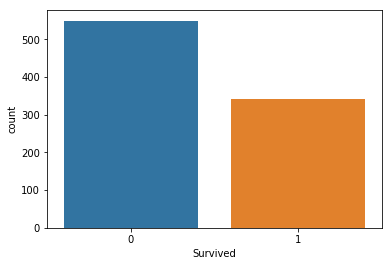

In [9]:
np.mean(train.Survived), sns.countplot(data=train, x="Survived")

Around 38,3% survived the Titanic.

#### Pclass

In [10]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Pclass is short for Passenger Class and gives the class to which the passenger belong. 1 is the most expensive class, 3 the cheapest one. As expected most passengers belong to class 3, while class 1 contains the least passengers.

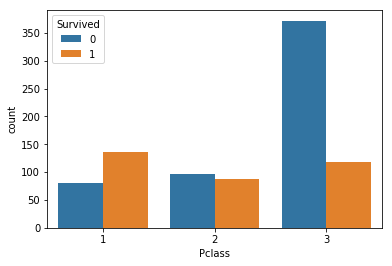

In [11]:
sns.countplot(data=train, x="Pclass", hue="Survived")

In [12]:
for i in [1,2,3]:
    print(np.mean(train.Survived[train["Pclass"]==i]))

0.6296296296296297
0.47282608695652173
0.24236252545824846


The fraction of passengers, which have survived is 63.0% for the first class, 47.3% for the second class and only 24.2% for the third class. The fraction of people surviving is therefore above the fraction of all people surviving the catastrophe for the first and second class and way below the mean for the third class. We can already see here that the class does play a very important role in surviving and that in the first class almost 2 out of 3 passengers survived.

#### Age

Since age is a continuous variable we can picture its distribution using a histogram and a kernel density estimator.

ValueError: ignored

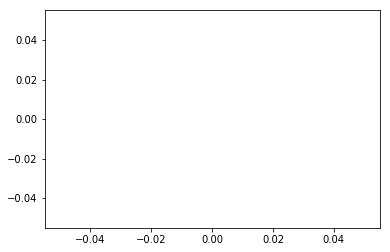

In [13]:
sns.distplot(train["Age"])

Running the above code yields an error since there are missing values for Age in the training dataset. Therefore, we first have to fix this issue.

In [14]:
train.Age.isnull().sum()

177

In [15]:
agemean1, agemean2, agemean3 = train["Age"].groupby([train["Pclass"]]).mean()
agemean1, agemean2, agemean3

(38.233440860215055, 29.87763005780347, 25.14061971830986)

There are 177 missing values for the Age. We compute the mean in each class and will use these means to impute the missing values in the training dataset.

In [16]:
miss_age = np.isnan(train["Age"])
class_1 = train["Pclass"] == 1
class_2 = train["Pclass"] == 2
class_3 = train["Pclass"] == 3
train.loc[class_1, "Age"] = train.loc[class_1, "Age"].fillna(agemean1)
train.loc[class_2, "Age"] = train.loc[class_2, "Age"].fillna(agemean2)
train.loc[class_3, "Age"] = train.loc[class_3, "Age"].fillna(agemean3)
train.Age.isnull().sum()

0

In [17]:
test.Age.isnull().sum()

86

We see that there are also missing values for age in the test data set, therefore we do the same thing for the test dataset.

In [18]:
agemean_1_test, agemean_2_test, agemean_3_test = test["Age"].groupby([test["Pclass"]]).mean()
agemean_1_test, agemean_2_test, agemean_3_test

(40.91836734693877, 28.7775, 24.02794520547945)

In [19]:
miss_age_test = np.isnan(test["Age"])
class_1_test = test["Pclass"] == 1
class_2_test = test["Pclass"] == 2
class_3_test = test["Pclass"] == 3
test.loc[class_1_test, "Age"] = test.loc[class_1_test, "Age"].fillna(agemean_1_test)
test.loc[class_2_test, "Age"] = test.loc[class_2_test, "Age"].fillna(agemean_2_test)
test.loc[class_3_test, "Age"] = test.loc[class_3_test, "Age"].fillna(agemean_3_test)
test.Age.isnull().sum()

0

Now we can again run the above code and plot the histogram.

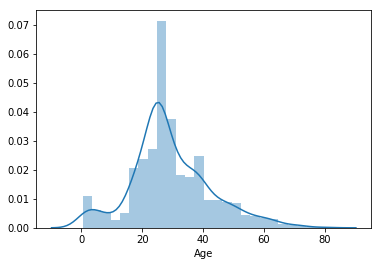

In [20]:
sns.distplot(train["Age"])

We can also plot the distribution of age by survival.

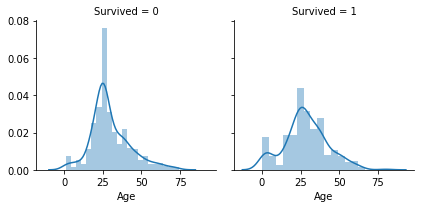

In [21]:
grid = sns.FacetGrid(data=train, col="Survived")
grid.map(sns.distplot, "Age")

#### SibSp

In [22]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

The variable SibSp contains information about the passenger having Siblings or Spouses aboart the titanic. Most people seem to be alone, or at least without any siblings or spouse. A large number of passengers do have 1 sibling or his/her spouse with them, those are probably mostly married couples. There also seem to be a few families.

#### Parch

In [23]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Similar to the variable before, "Parch" states the number of the passenger's parents or children aboard the ship. It also indicates that most passengers are alone, however, there seem to be a few families.

#### Fare

First, we take a look at the mean fares in the respective classes.

In [24]:
for i in [1,2,3]:
    print(np.mean(train.Fare[train["Pclass"] == i]))

84.15468749999992
20.66218315217391
13.675550101832997


As expected there is a drastic decline in the fare from the first to the third class. Let's see next if there is a systematic difference between the fare of male and female passengers.

In [25]:
for i in [1,2,3]:
    print("The Fare for female passengers in Class " + str(i) + " is: " + str(np.mean(train["Fare"].loc[(train["Pclass"] == i) & (train["Sex"] == "female")]))),
    print("The Fare for male passengers in Class " + str(i) + " is: " + str(np.mean(train["Fare"].loc[(train["Pclass"] == i) & (train["Sex"] == "male")])))
    print("\n")

The Fare for female passengers in Class 1 is: 106.12579787234041
The Fare for male passengers in Class 1 is: 67.22612704918033


The Fare for female passengers in Class 2 is: 21.97012105263158
The Fare for male passengers in Class 2 is: 19.74178240740741


The Fare for female passengers in Class 3 is: 16.118809722222224
The Fare for male passengers in Class 3 is: 12.661632564841513




The Fare seems to be higher for female passengers than for male passengers and this is also consistent over all classes.

In [26]:
for harb in ["C", "S", "Q"]:
    print("Mean fare for passengers embarked in " + str(harb) + ": " + str(np.mean(train.Fare[train["Embarked"] == harb])))

Mean fare for passengers embarked in C: 59.95414404761905
Mean fare for passengers embarked in S: 27.07981180124218
Mean fare for passengers embarked in Q: 13.276029870129872


Furthermore, the mean fare is the highest for people from Cherbourg and the lowest from passengers from Queenstown. An explanation for this is given further below (section Categorical Features -> Embarked). 
Queenstown, Southhampton

In [27]:
for harb in ["C", "S", "Q"]:
    print("Mean fare for 1st class passengers embarked in " + str(harb) + ": " + str(np.mean(train["Fare"].loc[(train["Embarked"] == harb) & (train["Pclass"] == 1)])))
    print("Mean fare for 2nd class passengers embarked in " + str(harb) + ": " + str(np.mean(train["Fare"].loc[(train["Embarked"] == harb) & (train["Pclass"] == 2)])))
    print("Mean fare for 3rd class passengers embarked in " + str(harb) + ": " + str(np.mean(train["Fare"].loc[(train["Embarked"] == harb) & (train["Pclass"] == 3)])))
    print("\n")

Mean fare for 1st class passengers embarked in C: 104.71852941176469
Mean fare for 2nd class passengers embarked in C: 25.358335294117644
Mean fare for 3rd class passengers embarked in C: 11.214083333333337


Mean fare for 1st class passengers embarked in S: 70.36486220472443
Mean fare for 2nd class passengers embarked in S: 20.327439024390245
Mean fare for 3rd class passengers embarked in S: 14.64408300283288


Mean fare for 1st class passengers embarked in Q: 90.0
Mean fare for 2nd class passengers embarked in Q: 12.35
Mean fare for 3rd class passengers embarked in Q: 11.183393055555557




We cann see that in addition to the different prices in the respective classes there was some price differentiation between the different harbours with Cherbourg being the most expensive one.

Comments on the relationship of Fares and the chance of Survival are made in the next section.

#### Correlation between variables

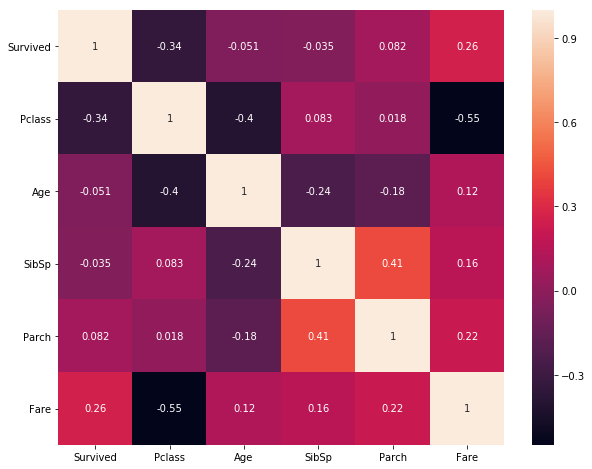

In [28]:
corr_mat = train.drop("PassengerId", axis=1).corr()
sns.heatmap(corr_mat, annot=True)
fig = plt.gcf()
fig.set_size_inches(10,8)

The above heatmap shows the correlation between all numerical variables including our Target Variable "Survived". A correlation of 1 means a very strong linear relationship, a correlation coefficient of -1 means a very strong negative linear relationship between variables. A correlation of 0 means that the variables do not have a linear relationship at all.

We can learn from the heatmap that there is a pretty strong negative correlation of -0.55 between the class and the fare, which makes sense since tickets for the first and second class are more expensive than for the third class. Furthermore, there seems to be a negative relationship between the class and the chance of survival indicated by the correlation coefficient of -0.34. We have also seen this in the barplots created above. The correlation between the Fare and Survived is pretty strong as well (0.26), which probably stems from the fact that higher fares coincide with a lower (i.e. "better") class. 
The high correlation between SibSp and Parch of 0.41 lets us assume that there may be some families aboard.

If there would be very high correlation between some variables, this specific variable would not contain much new information in addition to the correlated feature. This can cause our estimator to be less precise and is known as multicollinearity. The easiest and most appropriate solution would be just to drop one of the features or combining them in some way if possible. Since the highest correlation (in absolute values) is -0.55 multicollinearity is not a problem for our data and thus we can keep all of the features.

### Categorical Features

#### Sex 

(male      577
 female    314
 Name: Sex, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f83e31eecf8>)

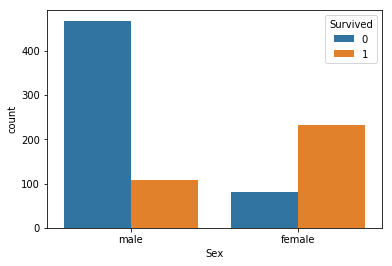

In [29]:
train.Sex.value_counts(), sns.countplot(data=train, x="Sex", hue="Survived")

In [30]:
print(np.mean(train.Survived[train["Sex"]=="male"]))
print(np.mean(train.Survived[train["Sex"]=="female"]))

0.18890814558058924
0.7420382165605095


We can see that the number of females that survived is a lot higher than the number of males surviving although the there are much more men on the Titanic than women (577 vs. 314). This is also reflected in the fraction of men and women who survived. While only 18.9% of the male passengers survived, over 74% of the female passengers survived the sinking.

Let's take a look if this pattern is consistent through all classes.

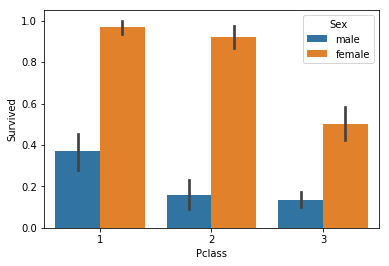

In [31]:
sns.barplot(data=train, x='Pclass', y='Survived', hue='Sex')

We have qualitatively the same picture for each class, although the survival rates are higher in the more expensive classes in general.

#### Cabin

In [32]:
train.Cabin.value_counts()

C23 C25 C27        4
B96 B98            4
G6                 4
C22 C26            3
E101               3
F2                 3
F33                3
D                  3
C65                2
B20                2
B5                 2
C78                2
B58 B60            2
E67                2
C126               2
B35                2
D17                2
F4                 2
C2                 2
B18                2
D35                2
D26                2
C68                2
B57 B59 B63 B66    2
B49                2
B22                2
E121               2
C52                2
B51 B53 B55        2
C123               2
                  ..
A32                1
B37                1
C54                1
E46                1
D46                1
E38                1
E10                1
D15                1
D37                1
D47                1
C106               1
A16                1
A23                1
E49                1
B4                 1
D10 D12            1
E40          

In [33]:
train.Cabin.isnull().sum()

687

Since there are mostly unique values and 687 missing values we will just drop the column completely.

In [0]:
train = train.drop("Cabin", axis=1)
test = test.drop("Cabin", axis=1)

#### Ticket

In [35]:
train["Ticket"].value_counts

<bound method IndexOpsMixin.value_counts of 0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
5                330877
6                 17463
7                349909
8                347742
9                237736
10              PP 9549
11               113783
12            A/5. 2151
13               347082
14               350406
15               248706
16               382652
17               244373
18               345763
19                 2649
20               239865
21               248698
22               330923
23               113788
24               349909
25               347077
26                 2631
27                19950
28               330959
29               349216
             ...       
861               28134
862               17466
863            CA. 2343
864              233866
865              236852
866       SC/PARIS 2149
867            PC 17590
868              345777
869              347

The "Ticket" feature contains the Ticket number. These are mainly unique values, therefore not adding much explanatory power to our prediction model. Thus, we just drop this column as well.

In [0]:
train = train.drop("Ticket", axis=1)
test = test.drop("Ticket", axis=1)

#### Embarked

In [37]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The categories of embarkment are C, Q and S which are the first letters of Cherbourg, Queenstown and Southhampton. Most passengers are embarked in Southhampton, the least frequent category is Queenstown.

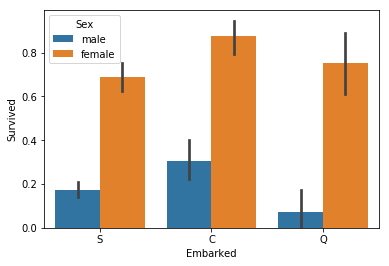

In [38]:
sns.barplot(data=train, x="Embarked", y="Survived", hue="Sex")

Interestingly, the fraction of people who survived is higher for Cherbourg. The fraction of male survivors is much higher in Southhampton compared to Queenstown, while the fraction of female survivors is higher for Queenstown compared to Southhampton. The high survival rates for Cherbourg might be high due to the fact that first class passengers are mostly compared in Cherbourg, so we will further investigate that now. 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


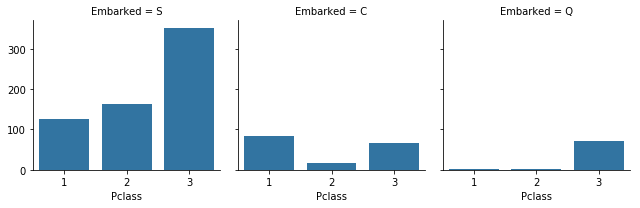

In [39]:
grid = sns.FacetGrid(data=train, col="Embarked")
grid.map(sns.countplot, "Pclass")

Cherbourg is the only category for which the number of first class passengers is the highest, which confirms the assumption from above. At the same time in Queenstown almost only third class passengers were embarked which explains the low survival rates for male passengers.

## Feature Engineering

In [40]:
X = train.drop("Survived", axis=1)
y = train["Survived"]
X["train"] = 1
test["train"] = 0
data = pd.concat([X, test])
X.shape, test.shape, data.shape

((891, 10), (418, 10), (1309, 10))

#### Age Band

Since age is a continuous variable we first want to convert into a categorical variable containing age bands. 

In [41]:
data.Age.describe()

count    1309.000000
mean       29.329730
std        13.127747
min         0.170000
25%        22.000000
50%        26.000000
75%        37.000000
max        80.000000
Name: Age, dtype: float64

The lowest value for Age in our datasets is 0.17 years, the oldest passenger is 80 years old. We want to convert the age into 5 categories. In order to get balanced groups we will orientate our splitting at percentiles.

In [42]:
data.Age.quantile([0.2, 0.4, 0.6, 0.8])

0.2    21.00000
0.4    25.14062
0.6    29.87763
0.8    39.00000
Name: Age, dtype: float64

In [0]:
data["age_cat"] = str(1)
data.loc[data["Age"] <= 21, "age_cat"] = str(1)
data.loc[(data["Age"] > 20) & (data["Age"] <= 25), "age_cat"] = str(2)
data.loc[(data["Age"] > 25) & (data["Age"] <= 30), "age_cat"] = str(3)
data.loc[(data["Age"] > 30) & (data["Age"] <= 40), "age_cat"] = str(4)
data.loc[data["Age"] > 40, "age_cat"] = str(5)

In [44]:
data.age_cat.value_counts()

3    318
2    267
1    248
4    240
5    236
Name: age_cat, dtype: int64

#### Child

In addition to the age category we just defined, we assume that being a child drastically increases the probability of surviving. Since our youngest age category ranges from newborn to 20 year olds, this is not really reflected by the data yet. We therefore define a dummy variable indicating if a passenger is a child. We do so by saying that children are people younger than 16.

In [0]:
data["child"] = 0
data.loc[data["Age"] <= 16, "child"] = 1

In [46]:
print(np.corrcoef(data.Age, data.age_cat))

TypeError: ignored

Since there is a very high positive correlation between Age and the categorical age variable (which is not surprising), we are going to drop the continuous age variable.

In [0]:
data = data.drop("Age", axis=1)

#### Fare bands

In the same way as with Age we can proceed with the fares paid by each passenger. Here, we will not define bands by hand, but we use the pandas function qcut. We use 10 categories to divide the fares into. After doing so, we can drop the original fare column. However, before we can create the bands we check for missing values.

In [48]:
data[data["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,train,age_cat,child
152,1044,3,"Storey, Mr. Thomas",male,0,0,NaN,S,0,5,0


The observation missing the Fare data belongs to the third class and was embarked in Southhampton. We will therefore impute the missing with the mean Fare of passengers from the third class embarked in Southhampton. Since we have seen before that the fares are systematically lower for male passengers we also take into account that the passenger with the missing fare value is male.

In [0]:
data.loc[data["Fare"].isnull(), "Fare"] = np.mean(data["Fare"].loc[(data["Pclass"] == 3) & (data["Embarked"] == "S") & (data["Sex"] == "male")])

Now we can continue creating the fare categories based on quantiles.

In [0]:
data["Fare_cat"] = pd.qcut(data["Fare"], 10)

In [0]:
data = data.drop("Fare", axis=1)

#### Family Size SibSp + ParCh

Since we have information about the number of Siblings and Spouses and about the number of parents or children for each passenger, we can use these features to create a feature that contains the number of a particular family that was aboard the ship. We call it family_size.

In [52]:
data["family_size"] = data["SibSp"] + data["Parch"] + 1
data.family_size.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: family_size, dtype: int64

We can now drop the features SibSp and Parch.

In [0]:
data = data.drop(["SibSp", "Parch"], axis=1)

#### Title

In [54]:
data.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Looking at the passenger's names, we notice that there are titles attached to them. The structure of this column is *"Last name, title first name"*. We can now extract those titles using regular expressions.

In [55]:
data["Title"] = data.Name.str.split(",", expand=True)[1].str.split(".", expand=True)[0]
data["Title"].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Ms                2
 Major             2
 Mlle              2
 the Countess      1
 Mme               1
 Lady              1
 Dona              1
 Jonkheer          1
 Sir               1
 Don               1
 Capt              1
Name: Title, dtype: int64

We see that the most frequent titles are simply Mr and Miss. We also see that there seem to be, for example, many different titles for women, e.g. Miss, Mrs, Ms, Mlle (Mademoiselle). We therefore group the titles into 5 categories: Mr, Mrs (married females), Miss, Master and other. 

In [0]:
#much more efficient and should work as well, however it does not here

#data["Title"] = data["Title"].replace(["Mlle", "Ms"], "Miss")
#data["Title"] = data["Title"].replace("Mme", "Mrs")
#data["Title"] = data["Title"].replace(["Don", "Dona", "Rev", "Dr", "Major", "Lady", "Sir", "Col", "Capt", "the Countess", "Jonkheer"], "Other")

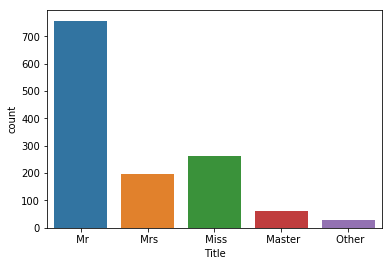

In [57]:
data["Title"] = data["Title"].apply(lambda x: x.replace("Mme", "Mrs"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Mlle", "Miss"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Ms", "Miss"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Dona", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Don", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Rev", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Dr", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Major", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Lady", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Sir", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Col", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Capt", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("the Countess", "Other"))
data["Title"] = data["Title"].apply(lambda x: x.replace("Jonkheer", "Other"))
sns.countplot(data=data, x="Title")

We can now drop the Name column.


In [0]:
data = data.drop("Name", axis=1)

#### Missings

Before starting the modelling part of this notebook, we take a quick look if there are any missing values in addition to those we already took care of.

In [59]:
data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Embarked       2
train          0
age_cat        0
child          0
Fare_cat       0
family_size    0
Title          0
dtype: int64

There are two more missing values for Embarked. We proceed in a similar manner as we have done so with Age above. However, instead of using means we impute the missings with the most frequent value in the respective class.

In [60]:
data[data["Embarked"].isnull()]

,PassengerId,Pclass,Sex,Embarked,train,age_cat,child,Fare_cat,family_size,Title
61,62,1,female,NaN,1,4,0,"(78.02, 512.329]",1,Miss
829,830,1,female,NaN,1,5,0,"(78.02, 512.329]",1,Mrs


In [61]:
data["Embarked"].loc[data["Pclass"] == 1].value_counts()

S    177
C    141
Q      3
Name: Embarked, dtype: int64

The most frequent value of Embarked for passengers in the first class is Southhampton.

In [0]:
data.loc[data["Embarked"].isnull(), "Embarked"] = "S"

In [63]:
data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Embarked       0
train          0
age_cat        0
child          0
Fare_cat       0
family_size    0
Title          0
dtype: int64

Our data looks good now, there are no more missing values.

#### Dummy variables

sklearn cannot handle categorical data, therefore we need to transform categorical features into dummy variables. If we have, for example, sex as a categorical feature ("male" or "female") and we convert this feature into dummies we get one dummy for "male" (0: no, 1: yes) and one for "female". Since both features are just linear combinations of each other (i.e. if we have the value for "male" we also have the value for "female") this would cause perfect multicollinearity. We therefore drop the first category dummy per feature to prevent this.

In [64]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,PassengerId,Pclass,train,child,family_size,Sex_male,Embarked_Q,Embarked_S,age_cat_2,age_cat_3,age_cat_4,age_cat_5,"Fare_cat_(7.57, 7.854]","Fare_cat_(7.854, 8.05]","Fare_cat_(8.05, 10.5]","Fare_cat_(10.5, 14.454]","Fare_cat_(14.454, 21.558]","Fare_cat_(21.558, 26.82]","Fare_cat_(26.82, 41.579]","Fare_cat_(41.579, 78.02]","Fare_cat_(78.02, 512.329]",Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Other
0,1,3,1,0,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,3,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,4,1,1,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,5,3,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


We can now split our data again into the training and the test set. To do so, we have defined a binary variable "train" before concatenating both data frames. We can now use this indicator to split them again. After doing so, we drop the PassengerId in since it does not add any information to our model. 

In [71]:
X = data[data["train"]==1]
X = X.drop("PassengerId", axis=1)
test = data[data["train"]==0]
ID = test["PassengerId"] # saving the test set PassengerId for submission file
test = test.drop("PassengerId", axis=1)
X.shape, y.shape, test.shape

((891, 24), (891,), (418, 24))

## Building a Model

We will try 2 different algorithms: a Random Forest Classifier and XGBoost Classifier. Since the Kaggle Leaderboard is based on the accuracy, i.e. the percentage of correctly classified samples, we will also use this metric to evaluate our models using k-fold cross-validation on a hold-out (test) set.

### Random Forest 

We are going to start with the Random Forest Classifier.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

At first we have to split our data into a training set and a test set, on which the models can be evaluated on later.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 24), (179, 24), (712,), (179,))

Then we will create our pipeline object, define the functions that should be applied and define a grid with the parameters we want to tune and the range from which RandomizedSearchCV shoud draw from.

In [0]:
steps_rf = [("scaler", preprocessing.StandardScaler()), ("rf_class", RandomForestClassifier(random_state=123))]
pipeline_rf = Pipeline(steps_rf)

# define our hyperparameter grid
n_estimators = list(np.arange(200, 2001, 200))
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 101, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
param_dist = {"rf_class__n_estimators": n_estimators,
              "rf_class__max_features": max_features,
              "rf_class__max_depth": max_depth,
              "rf_class__min_samples_split": min_samples_split,
              "rf_class__min_samples_leaf": min_samples_leaf,
              "rf_class__bootstrap": bootstrap}

We can now start to narrow down the range for our hyperparameters by using using RandomizedSearchCV to get a first hint of the ideally chosen hyperparameters for our data.

In [0]:
cv_random_rf = RandomizedSearchCV(pipeline_rf, param_dist, cv=5, n_iter=500)

In [78]:
cv_random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('rf_class',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                         

In [79]:
cv_random_rf.best_params_

{'rf_class__bootstrap': True,
 'rf_class__max_depth': 10,
 'rf_class__max_features': 'auto',
 'rf_class__min_samples_leaf': 4,
 'rf_class__min_samples_split': 5,
 'rf_class__n_estimators': 600}